# Overview
In this notebook we will consider vibrational strong coupling between a cavity and the HF molecule where the cavity
is tuned to the fundamental transition of HF within the Harmonic Oscillator approximation.  

We will deploy two different Hamiltonians: The minimal coupling Hamiltonian (`` p dot A ''), and the `` d dot E'' Hamiltonian from Eq. (31) and Eq. (48) of Chapter 2.

The form of these coupled Hamiltonians are
\begin{equation}
    \hat{H}_{\rm p \cdot A} = \hat{H}_{\rm m} + \hat{H}_{\rm c} - i z \sqrt{\frac{ \hbar \omega_{\rm f}}{2 \mu}} {\bf A}_0 (\hat{a}^{\dagger} - \hat{a})  (\hat{b}^{\dagger} + \hat{b})+ \frac{z^2}{2\mu} {\bf A}_0^2 ( \hat{b}^{\dagger} \hat{b}^{\dagger} + \hat{b}\hat{b}  + 2\hat{b}^{\dagger}\hat{b}  + 1),
\end{equation}
for the minimal coupling Hamiltonian, and 
\begin{equation}
    \hat{H}_{\rm d \cdot E} = \hat{H}_{\rm m} + \hat{H}_{\rm c} + i z \frac{\hbar}{2} \sqrt{\frac{\omega_{\rm cav}}{\mu \omega_{\rm f}}} {\bf E}_0 (\hat{a}^{\dagger} + \hat{a}) (\hat{b}^{\dagger} - \hat{b}) + z^2\frac{\hbar}{4\mu \omega_{\rm f}} {\bf E}_0^2 (\hat{a}^{\dagger} \hat{a}^{\dagger} + \hat{a}\hat{a}  + 2\hat{a}^{\dagger}\hat{a}  + 1)
\end{equation}
for the d dot E Hamiltonian.

Here, $z$ is the effective charge of the HF molecule, $\mu$ is the reduced mass of the HF molecule,
\begin{equation}
\mu = \frac{m_F \cdot m_H}{m_F + m_H}
\end{equation}
and we will define the potential $V(x)$ to be the Harmonic potential of HF as,
\begin{equation}
V(x) = \frac{1}{2} k x^2.
\end{equation}

# Unit system
We will work in atomic units.  In atomic units, so the mass of H and F, the Harmonic force constant, the cavity frequency, the charge
associated with the dipole operator, and the vector potential must all be expressed in atomic units.  We will consider an arbitrary range of values for the vector potential, but all other values will be fixed as follows:

| Quantity    | Value in Atomic Units |
| -------- | ------- |
| mass of F  | 34616.6811    |
| mass of H  | 1837.4731    |
| Force Constant  of HF* |  0.6377 |
| Equilibrium bondlength* | 1.7310 |
| Charge*   | -0.4688 |
| Cavity frequency* | 0.01911


The force constant, charge, and cavity frequency are all quantities that we have derived from some calculations.  
We estimated the force constant using quantum chemistry calculations, specifically using numerical derivatives of CCSD(T)/cc-pVTZ 
energies about the equilibrium geometry located by a geometry optimization at the same level.  Similarly, we computed the RHF/cc-pVTZ dipole moment at this optimized geometry and derived the effective charge as the dipole moment divided by the equilibrium bond length.  The
cavity frequency is matched to the fundamental frequency of HF, which is derived from the Harmonic approximation as follows:
\begin{equation}
\omega_{\rm cav} = \omega_{\rm f} = \sqrt{ \frac{k}{\mu} }
\end{equation}
where $k$ is the force constant and $\mu$ is the reduced mass and $\omega_{\rm f}$ indicates the fundamental frequency of the HF molecule.

In [1]:
import numpy as np
from numpy import linalg as la

# Force constant of HF in atomic units as computed using centered finite differences at the CCSD(T)/cc-pVTZ level 
# about an equilibrium bondlength of 1.73106 atomic units (0.9160 Angstroms )
k_au = 0.6377016832933821

# reduced mass of HF
mF_au = 34616.6811
mH_au = 1837.4731

mu_au = mF_au * mH_au / (mF_au + mH_au)

# fundamental frequency of HF in atomic units
omega_au = np.sqrt( k_au / mu_au )

# set cavity frequency equal to fundamental
omega_cav  = omega_au

# set charge
z_au = -0.4688

print(F' Cavity Frequency in Atomic Units is {omega_cav}')



 Cavity Frequency in Atomic Units is 0.019117411406998054


With these basic parameters having been computed or assigned, we will write functions that compute matrix
elements of each term in the two Hamiltonians we are considering.  These functions will all have a common structure that 
they will take arguments that specify the matter and photonic basis functions for the bra and ket, and any relevant parameters, and will return the value of the matrix element.  We will reiterate the relevant matrix element above each block for clarity.

The function `compute_matter_matrix_element(q_m, q_p, r_m, r_p, k, mu)` will compute the pure matter matrix elements
\begin{equation}
\langle q_m | \langle q_p | \frac{\hat{p}^2}{2\mu} + \frac{1}{2} k \hat{x}^2| r_m \rangle | r_p \rangle = \hbar \omega_{\rm f} (r_m + \frac{1}{2}) \delta_{q_m, r_m} \delta_{q_p, r_p}
\end{equation}
which is the same for both the minimal coupling and the d dot E Hamiltonians.

In [2]:
def compute_matter_matrix_element(q_m, q_p, r_m, r_p, k, mu):
    """ 
    Arguments
    ---------
    q_m : int
        matter bra index

    q_p : int
        photonic bra index

    r_m : int
        matter ket index

    r_p : int
        photon ket index

    k : float
        force constant

    mu : float
        reduced mass

    Returns
    -------

    E_matter : float
        Matter matrix element 
    """
    # compute the magnitude of the matrix element
    E_matter = np.sqrt( k / mu) * (r_m + 1/2)
    
    # returns only if diagonal in matter and photon bra and kets
    return E_matter * (q_m == r_m) * (q_p == r_p)


The function `compute_photon_matrix_element(q_m, q_p, r_m, r_p, omega_cav)` will compute the pure photon matrix elements
\begin{equation}
\langle q_m | \langle q_p | \hbar \omega_{\rm cav} (\hat{b}^{\dagger} \hat{b} + \frac{1}{2} ) | r_m \rangle | r_p \rangle = \hbar \omega_{\rm cav} (r_p + \frac{1}{2}) \delta_{q_m, r_m} \delta_{q_p, r_p}
\end{equation}
which is the same for both the minimal coupling and the d dot E Hamiltonians.

In [17]:
def compute_photon_matrix_element(q_m, q_p, r_m, r_p, omega_cav):
    """ 
    Arguments
    ---------
    q_m : int
        matter bra index

    q_p : int
        photonic bra index

    r_m : int
        matter ket index

    r_p : int
        photon ket index

    omega_cav : float
        cavity frequency

    Returns
    -------

    E_photon : float
        Photon matrix element 
    """
    # compute the magnitude of the matrix element
    E_photon = omega_cav * (r_p + 1/2 * 0)
    
    # returns only if diagonal in matter and photon bra and kets
    return E_photon * (q_m == r_m) * (q_p == r_p)

The function `compute_diamagnetic_element_p_dot_A(q_m, q_p, r_m, r_p, z_charge, A0, m)` computes the matrix element of 

\begin{align}
& \langle q_m | \langle q_p | \frac{z^2}{2\mu}  {\bf A}_0^2 ( \hat{b}^{\dagger} + \hat{b})^2 | r_m \rangle | r_p \rangle  \\
&  \langle q_m | \langle q_p | \frac{z^2}{2\mu} {\bf A}_0^2 ( \hat{b}^{\dagger} \hat{b}^{\dagger} + \hat{b}\hat{b}  + 2\hat{b}^{\dagger}\hat{b}  + 1) | r_m \rangle | r_p \rangle  \\
= & \delta_{q_m, r_m} \left(\frac{z^2}{2\mu} {\bf A}_0^2 ( ( 2 r_p + 1)\delta_{q_p, r_p} +  \sqrt{r_p + 1} \sqrt{r_p + 2} \delta_{q_p, r_p+2} 
+ \sqrt{r_p} \sqrt{r_p -1} \delta_{q_p, r_p-2})
\right)
\end{align}

In [18]:
    
def compute_diamagnetic_element_p_dot_A(q_m, q_p, r_m, r_p, z_charge, A0, mu):
    """ 
    Arguments
    ---------
    q_m : int
        matter bra index

    q_p : int
        photonic bra index

    r_m : int
        matter ket index

    r_p : int
        photon ket index

    z_charge : float
        the effective charge of the matter subsystem

    A0 : float
        the magnitude of the vector potential of the photonic subsystem

    mu : float
        the reduced mass of the matter subsystem

    Returns
    -------

    E_diamag : float
        Diamagnetic matrix element 
    """
    fac = z_charge ** 2 * A0 ** 2 / ( 2 * mu)

    # must be diagonal in photon space
    E_diamag = 0
    if q_m == r_m:
        if q_p == r_p:
            E_diamag = 2 * fac * (r_p + 1/2)
        
        elif q_p == r_p + 2:
            E_diamag = fac * np.sqrt(r_p + 1) * np.sqrt(r_p + 2)
        elif q_p == r_p - 2:
            E_diamag = fac * np.sqrt(r_p) * np.sqrt(r_p - 1)
        else:
            E_diamag = 0
            
    return E_diamag
    

The function `compute_interaction_matrix_element_p_dot_A(q_m, q_p, r_m, r_p, m, k, z_charge, A0)` computes the matrix element of
\begin{align}
&- i z \sqrt{\frac{ \hbar \omega_{\rm f}}{2\mu}} {\bf A}_0  \langle q_m | \langle q_p |  (\hat{a}^{\dagger} - \hat{a})  (\hat{b}^{\dagger} + \hat{b}) | r_m \rangle | r_p \rangle  \\
&= - i z \sqrt{\frac{ \hbar \omega_{\rm f}}{2\mu}} {\bf A}_0 \langle q_m | (\hat{a}^{\dagger} - \hat{a})   | r_m \rangle  \langle q_p |(\hat{b}^{\dagger} + \hat{b}) | r_p \rangle \\
&= - i z\sqrt{\frac{\hbar \omega_{\rm f}}{2\mu}}{\bf A}_0  (\sqrt{r_m+1} \delta_{q_m,r_m+1} - \sqrt{r_m} \delta_{q_m, r_m-1} ) ( \sqrt{r_p+1} \delta_{q_p,r_p+1} + \sqrt{r_p} \delta_{q_p, r_p-1}) 
\end{align}
which is unique to the p dot A Hamiltonian.

In [19]:
def compute_interaction_matrix_element_p_dot_A(q_m, q_p, r_m, r_p, mu, k, z_charge, A0):
    """ 
    Arguments
    ---------
    q_m : int
        matter bra index

    q_p : int
        photonic bra index

    r_m : int
        matter ket index

    r_p : int
        photon ket index

    mu : float
        the reduced mass of the matter subsystem

    k : float 
        the force constant of the matter subsystem

    z_charge : float
        the effective charge of the matter subsystem

    A0 : float
        the magnitude of the vector potential of the photonic subsystem

    Returns
    -------

    E_coupling : float
        coupling matrix element
    """
    omega_f = np.sqrt( k / mu) 
    
    
    fac = -1j * z_charge * np.sqrt( omega_f / (2 * mu) ) * A0

    # matter terms
    if q_m == r_m+1:
        term_1 = np.sqrt(r_m + 1)
    else:
        term_1 = 0
     
    if q_m == r_m-1:
        term_2 = -np.sqrt(r_m)
    else:
        term_2 = 0
    
    # photon terms
    if q_p == r_p+1:
        term_3 = np.sqrt(r_p + 1)
    else:
        term_3 = 0
        
    if q_p == r_p-1:
        term_4 = np.sqrt(r_p)
    else:
        term_4 = 0

    E_coupling = fac * (term_1 + term_2) * (term_3 + term_4)
        
    return E_coupling

The function `compute_interaction_matrix_element_d_dot_E(q_m, q_p, r_m, r_p, omega_p, z_charge, E0, k, mu)` will compute 
matrix elements of 
$ + i z \frac{\hbar}{2} \sqrt{\frac{\omega_{\rm cav}}{\mu \omega_{\rm f}}} {\bf E}_0 (\hat{a}^{\dagger} + \hat{a}) (\hat{b}^{\dagger} - \hat{b})$
\begin{align}
& i z \frac{\hbar}{2} \sqrt{\frac{\omega_{\rm cav}}{\mu \omega_{\rm f}}} {\bf E}_0\langle q_m | \langle q_p |(\hat{a}^{\dagger} + \hat{a}) (\hat{b}^{\dagger} - \hat{b}) | r_m \rangle | r_p \rangle \\
=& i z \frac{\hbar}{2} \sqrt{\frac{\omega_{\rm cav}}{\mu \omega_{\rm f}}} {\bf E}_0 \langle q_m | (\hat{a}^{\dagger} + \hat{a}) | r_m \rangle \langle q_p | (\hat{b}^{\dagger} - \hat{b})  | r_p \rangle \\
=& i z \frac{\hbar}{2} \sqrt{\frac{\omega_{\rm cav}}{\mu \omega_{\rm f}}} {\bf E}_0 (\sqrt{r_m+1} \delta_{q_m,r_m+1} + \sqrt{r_m} \delta_{q_m, r_m-1} ) ( \sqrt{r_p+1} \delta_{q_p,r_p+1} - \sqrt{r_p} \delta_{q_p, r_p-1})
\end{align}

In [20]:
def compute_interaction_matrix_element_d_dot_E(q_m, q_p, r_m, r_p, omega_p, z_charge, E0, k, mu):
    """ 
    Arguments
    ---------
    q_m : int
        matter bra index

    q_p : int
        photonic bra index

    r_m : int
        matter ket index

    r_p : int
        photon ket index

    omega_p : float
        photon frequency
    
    z_charge : float
        the effective charge of the matter subsystem

    E0 : float
        the magnitude of the electric field of the photonic subsystem

    k : float 
        the force constant of the matter subsystem

    mu : float
        the reduced mass of the matter subsystem

    Returns
    -------

    E_coupling : float
        coupling matrix element
    """
    hbar = 1 # plancks constant / 2 * pi in atomic units
    omega_f = np.sqrt( k / mu) 
    
    fac = 1j * z_charge / 2 * np.sqrt(omega_p / (mu * omega_f)) * E0
    
    # matter terms
    if q_m == r_m+1:
        term_1 = np.sqrt(r_m + 1)
    else:
        term_1 = 0
     
    if q_m == r_m-1:
        term_2 = np.sqrt(r_m)
    else:
        term_2 = 0
    
    # photon terms
    if q_p == r_p+1:
        term_3 = np.sqrt(r_p + 1)
    else:
        term_3 = 0
        
    if q_p == r_p-1:
        term_4 = np.sqrt(r_p)
    else:
        term_4 = 0

    E_coupling = fac * (term_1 + term_2) * (term_3 - term_4)
        
    return E_coupling

The function `compute_dipole_self_energy_d_dot_E(q_m, q_p, r_m, r_p, omega_p, z_charge, E0, k, mu)` computes the matrix element of 

$ z^2\frac{\hbar}{4\mu \omega_{\rm f}} {\bf E}_0^2 (\hat{a}^{\dagger} \hat{a}^{\dagger} + \hat{a}\hat{a}  + 2\hat{a}^{\dagger}\hat{a}  + 1) $
\begin{align}
&   z^2\frac{\hbar}{4\mu \omega_{\rm f}} {\bf E}_0^2  \langle q_m | \langle q_p |  (\hat{a}^{\dagger} \hat{a}^{\dagger} + \hat{a}\hat{a}  + 2\hat{a}^{\dagger}\hat{a}  + 1) | r_m \rangle |  r_p \rangle  \\
&= z^2\frac{\hbar}{4\mu \omega_{\rm f}} {\bf E}_0^2  \langle q_m | (\hat{a}^{\dagger} \hat{a}^{\dagger} + \hat{a}\hat{a}  + 2\hat{a}^{\dagger}\hat{a}  + 1) | r_m \rangle   \langle q_p |   r_p \rangle \\
&=  z^2\frac{\hbar}{4\mu \omega_{\rm f}} {\bf E}_0^2  ( (2 r_m + 1) \delta_{q_m, r_m} +  \sqrt{r_m + 1} \sqrt{r_m + 2} \delta_{q_m, r_m+2} + \sqrt{r_m} \sqrt{r_m -1} \delta_{q_m, r_m-2}) \delta_{q_p, r_p}\\
\end{align}

In [21]:
def compute_dipole_self_energy_d_dot_E(q_m, q_p, r_m, r_p, omega_p, z_charge, E0, k, mu):
    """ 
    Arguments
    ---------
    q_m : int
        matter bra index

    q_p : int
        photonic bra index

    r_m : int
        matter ket index

    r_p : int
        photon ket index

    omega_p : float
        photon frequency
    
    z_charge : float
        the effective charge of the matter subsystem

    A0 : float
        the magnitude of the vector potential of the photonic subsystem

    k : float 
        the force constant of the matter subsystem

    mu : float
        the reduced mass of the matter subsystem

    Returns
    -------

    E_dse : float
        dipole self energy matrix element
    """
    hbar = 1
    omega_f = np.sqrt( k / mu )
    fac = z_charge ** 2 * hbar / (4 * mu * omega_f) * E0 ** 2

    # must be diagonal in photon space
    val = 0
    if q_p == r_p:
        if q_m == r_m:
            val = 2 * fac * (r_m + 1/2)
        
        elif q_m == r_m + 2:
            val = fac * np.sqrt(r_m + 1) * np.sqrt(r_m + 2)
        elif q_m == r_m - 2:
            val = fac * np.sqrt(r_m) * np.sqrt(r_m - 1)
        else:
            val = 0
            
    return val
    

The following functions will build the basis used for these matrices, and will build these matrices and diagonalize them, returning both their eigenvectors and eigenvalues.  

In [22]:
def build_basis(photon_dim, matter_dim):
    basis = []
    for i in range(photon_dim):
        for j in range(matter_dim):
            basis.append((j,i))
    return basis


def build_and_diagonalize_p_dot_A(basis, k, mu, omega, z, A0):
    # length of slice of first column gives us the dimension of the Hamiltonian
    dim = len(basis)
    
    # initialize our Hamiltonian
    H_pda = np.zeros((dim,dim), dtype=complex)


    ket_idx = 0
    for ket in basis:

        bra_idx = 0
        
        for bra in basis:
            # matter term
            H_m_element = compute_matter_matrix_element(bra[0], bra[1], ket[0], ket[1], k, mu)
            # photon term
            H_p_element = compute_photon_matrix_element(bra[0], bra[1], ket[0], ket[1], omega)
            # interaction term
            H_i_element = compute_interaction_matrix_element_p_dot_A(bra[0], bra[1], ket[0], ket[1], mu, k, z, A0) 
            # diamagnetic term 
            H_d_element = compute_diamagnetic_element_p_dot_A(bra[0], bra[1], ket[0], ket[1], z, A0, mu)

            H_pda[bra_idx, ket_idx] = H_m_element + H_p_element + H_i_element  + H_d_element 
            bra_idx = bra_idx + 1
        ket_idx = ket_idx + 1 #ket_idx += 1
    
    # compute eigenvalues and eigenvectors
    vals, vecs = la.eigh(H_pda)
    
    # only return vals
    return H_pda, vals

def build_and_diagonalize_d_dot_E(basis, k, mu, omega, z, A0):
    # length of slice of first column gives us the dimension of the Hamiltonian
    dim = len(basis)
    
    # hbar in atomic units
    hbar = 1
    
    # initialize our Hamiltonian
    H_dE = np.zeros((dim,dim), dtype=complex)
    
    # convert A0 to E0
    E0 = np.sqrt( 2 * omega / hbar) * A0


    ket_idx = 0
    for ket in basis:

        bra_idx = 0
        
        for bra in basis:

            H_m_element = compute_matter_matrix_element(bra[0], bra[1], ket[0], ket[1], k, mu)

            H_p_element = compute_photon_matrix_element(bra[0], bra[1], ket[0], ket[1], omega)

            H_i_element = compute_interaction_matrix_element_d_dot_E(bra[0], bra[1], ket[0], ket[1], omega, z, E0, k, mu)

            H_dse_element = compute_dipole_self_energy_d_dot_E(bra[0], bra[1], ket[0], ket[1], omega, z, E0, k, mu)

            H_dE[bra_idx, ket_idx] = H_m_element + H_p_element + H_i_element + H_dse_element 
            
            bra_idx = bra_idx + 1
        
        ket_idx = ket_idx + 1 #ket_idx += 1
    
    # compute eigenvalues and eigenvectors
    vals, vecs = la.eigh(H_dE)
    
    # only return vals
    return H_dE, vals





In [25]:
basis_array = build_basis(3, 3)
k_val = k_au
mu_val = mu_au
z_val = z_au
omega_p_val = np.sqrt( k_au / mu_au)
A0_val = 2.0

H_pda, vals_pda = build_and_diagonalize_p_dot_A(basis_array, k_val, mu_val, omega_p_val, z_val, A0_val)
H_PF, vals_PF = build_and_diagonalize_d_dot_E(basis_array, k_val, mu_val, omega_p_val, z_val, A0_val)

print(vals_pda)
print(vals_PF)

assert np.allclose(vals_pda, vals_PF)

[0.00968428 0.02673753 0.03112656 0.04399225 0.04853453 0.05273993
 0.06375603 0.07257691 0.0877953 ]
[0.00968428 0.02673753 0.03112656 0.04399225 0.04853453 0.05273993
 0.06375603 0.07257691 0.0877953 ]


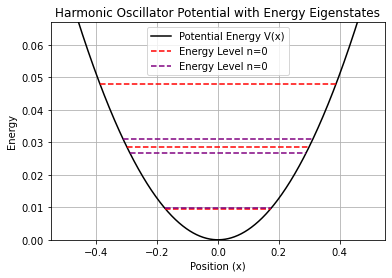

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
m = mu_au  # mass (arbitrary units)
omega = np.sqrt( k_au / mu_au )  # angular frequency (arbitrary units)
hbar = 1.0  # reduced Planck's constant (arbitrary units)

# Potential energy function for harmonic oscillator
def potential(x):
    return 0.5 * m * omega**2 * x**2

# Energy eigenvalues for harmonic oscillator
def energy(n):
    return hbar * omega * (n + 0.5)

# Turning points for each energy level
def turning_points(E_n):
    #E_n = energy(n)
    x_max = np.sqrt(2 * E_n / (m * omega**2))
    return -x_max, x_max

# Define range for x
x = np.linspace(-0.5, 0.5, 1000)
V = potential(x)

# Plot the potential
plt.plot(x, V, label='Potential Energy V(x)', color='black')

# Plot the energy eigenstates
n_max = 3  # number of eigenstates to plot
for n in range(n_max):
    E_n = energy(n)
    pol_En = vals_PF[n]
    x_min, x_max = turning_points(E_n)
    pol_x_min, pol_x_max = turning_points(pol_En)
    plt.hlines(E_n, x_min, x_max, color='red', linestyle='--', label=f'Energy Level n={n}' if n == 0 else None)
    plt.hlines(pol_En, pol_x_min, pol_x_max, color='purple', linestyle='--', label=f'Energy Level n={n}' if n == 0 else None)

# Add labels and legend
plt.title('Harmonic Oscillator Potential with Energy Eigenstates')
plt.xlabel('Position (x)')
plt.ylabel('Energy')
plt.ylim(0, energy(n_max))
plt.legend()
plt.grid()

# Show the plot
plt.show()